# PlateMappy 
This is a small tool that generates plate maps. 

You generate a platemap by instatiating an object of the `Metadata` class from your own metadata, by running 
`Metdata()`. The following options are provided in this function: 
- `n_ag`: the number of AG per plate, randomly distributed
- `n_canary`: the number of Canaries per plate, randomly distributed
- `n_mAb`: the number of antibody controls (eg, GFAP) per plate
- `block_`: number of wells to assign to a contiguous block. this is useful if you want to plate your healthy controls in a contiguous block (see ex 1)
- `duplicate`: can preform techincal replicates of each sample ,

In [184]:
import pandas as pd
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.lines as mlines

class Metadata:
    """
    This is a metadata class that generates plate maps.

    Parameters:
        X: pd.DataFrame
            metadata obj, index=samples
        disease_map: str
            column name of x that is binary map for disease vs healthy: {1:disease, 0:healthy}
        n_ag: int
            number AG, per plate 
        n_canary: int
            number Canary, per plate 
        n_mAb: int
            number mAb, per plate 
        block_: int, default None
            size of continguious block to be added to plates
        duplicate_: int, default None 
            number of duplicates of each sample, total

    Attributes:
        pmaps: list of (8,12) dataframes
            96 well plate maps, with sample ids or controls as values
    """

    def __init__(self, 
                 X: pd.DataFrame, 
                 disease_map: str,
                 n_ag: int, 
                 n_canary: int, 
                 n_mAb: int, 
                 block_: int, 
                 duplicate_: int) -> None:
        self._X = X
        self._disease_map = disease_map
        self._ag = n_ag
        self._can = n_canary
        self._mab = n_mAb
        self._block=block_
        self._dup=duplicate_

        self.k = self._init_params() 
    
    def _init_params(self):
        """ 
        Calculates number of plates. 

        Returns: 
            n: int
                number of healthies
            m: int
                number of patients
            k: 
                number of plates
        """
        x = self._ag + self._can + self._mab # total controls per plate

        #plates is the total number of samples that fit into 96 well plate (minus controls), with round up
        if self._block and not self._dup: 
            k = math.ceil((self._X.shape[0])/(96-x-self._block))
        elif self._block and self._dup: 
            k = math.ceil((self._X.shape[0]*self._dup)/(96-x-self._block))
        elif self._dup and not self._block: 
            k = math.ceil((self._X.shape[0]*self._dup)/(96-x))
        else: 
            k = math.ceil((self._X.shape[0])/(96-x)) 

        return k
    
    def allocate_samples_to_plate(self)-> dict:
        """ 
        divides samples to different plates. the ratio of healthy to disease will be maintained in 
        this division (m/n = (m/k)/(n/k)), so don't need to worry about that. 

        Returns: 
            samples_to_plates: dict
                dictionary where keys are plate numbers 1..k and values are lists of healthies/disease. 

        """
        samples_to_plates={(i+1):list() for i in range(self.k)}
        
        for c in self._X[self._disease_map].unique():
            samples_c=self._X.index[self._X[self._disease_map]==c].tolist()

            # duplicate samples if needed
            if self._dup:
                samples_c=np.repeat(samples_c, self._dup) # this duplicates every value in the list

            #shuffle
            random.shuffle(samples_c)

            #find split to plates
            d=math.ceil(len(samples_c)/self.k)

            #allocate shuffled samples to plates
            for i in range(self.k-1):
                samples_to_plates[i+1].extend(samples_c[i*d:(i+1)*d])
            i=self.k-2
            samples_to_plates[self.k].extend(samples_c[(i+1)*d:])
        
        return samples_to_plates
        
    
    def create_plates(self, samples_to_plates) -> dict:
         """ 
        creates plates with the randomly allocated samples and controls.


        Returns: 
            plates: dict
                dictionary where keys are plate numbers 1..k and values are arrays. 

        """
         plates={}

         #generate number of controls per plate
         AG=['AG']*self._ag
         Canary=['Canary']*self._can
         mAb=['mAb']*self._mab
         
         #randomly shuffle samples and controls
         for i in range(self.k):
             samples=samples_to_plates[i+1]
             print(len(samples))
             samples.extend(AG)
             samples.extend(Canary)
             samples.extend(mAb)
            # all_vals=[samples_to_plates[i+1].extend(l) for l in [AG, Canary, mAb]] # concatenate all values
             random.shuffle(samples) # shuffle

             if self._block: 
                insert_loc=random.choice(range(96-self._block))
                for z in range(self._block):
                    samples.insert(insert_loc,'HC')
            
             #if not full 96 well plate, pad with zeros
             if len(samples)<96: 
                samples.extend([0]*(96-len(samples)))
             
             plates[i+1]=np.reshape(samples, (8,12))

         return plates
    
    def save_plates(plate_dict, base_path)->None: 
        """
        saves your plates into csv format 

        Parameters:
            plate_dict: dict
                dictionary of k 96-well plates
            base_path: str
                path to save the csv files
        """
        for p in plate_dict.keys(): 
            X=plate_dict[p]
            pd.DataFrame(data=X, columns=['1','2','3','4','5','6','7','8','9','10','11','12'], 
            index=['A','B','C','D','E','F','G','H']).to_csv(base_path+'plate_{}.csv'.format(p))
        return None

    def view_plate(self, plate, view_bin=False, key=False, save=False, save_loc=None) -> None: 
        """
        plotting function to visualize a plate layout 

        Parameters: 
            plate: np.array 
                8x12 array with ID
            view_bin: bool, default=False
                

            v
        """
        fig, ax = plt.subplots(figsize=(15,10))

        #number of categories
        cats=self._X[self._disease_map].unique()
        n_cats=len(cats)

        # make the colormap for disease categories
        default_colors=['lightgreen','cornflowerblue','turquoise','deepskyblue','dodgerblue','seafoamgreen','lightgreen'] #colors for sample categories   
        cmap_=ListedColormap(default_colors[:n_cats]+['tomato','gold','darkorange','lemonchiffon','lightgrey']) # add in colors for control catgeories
        norm_=BoundaryNorm([0.5+x for x in range(-1,n_cats+4,1)]+[1000.5], cmap_.N) #define boundaries for cmap

        #binarize all labels 
        bin_ctrls={'AG':n_cats, 'Canary':n_cats+1, 'mAb':n_cats+2, 'HC':n_cats+3, '0':1000}
        bin_ctrls.update(self._X[self._disease_map].to_dict())
        bin_plate=np.vectorize(bin_ctrls.get)(plate)    

        for i in range(8):
            for j in range(12):
                if view_bin:
                    c=bin_plate[i,j]
                else: 
                    c=plate[i,j]
                ax.text(j, i, c, va='center', ha='center')
                ax.vlines(j+0.5, ymin=-.5,ymax=8.5, color='black')
                ax.hlines(i+0.5, xmin=-.5, xmax=12.5, color='black')

        if key: 
            handles_=[]
            for k in range(n_cats): 
                handles_.append(mlines.Line2D([],[], color=default_colors[k], marker='s', linestyle='None',
                          markersize=10, label=cats[k]))
            handles_.append(mlines.Line2D([],[], color='lemonchiffon', marker='s', linestyle='None',
                          markersize=10, label='Healthy Control'))
            plt.legend(handles=handles_, bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

        ax.matshow(bin_plate, cmap=cmap_, norm=norm_)

        ax.set_xticks(range(12))
        ax.xaxis.tick_top()
        ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12'], fontsize='x-large')

        ax.set_yticks(range(8))
        ax.set_yticklabels(['A','B','C','D','E','F','G','H'], fontsize='x-large')
        
        plt.show()



# example 1: hannah's endometriosis plates
In this run, Hannah had internal controls within her cohort and then added additional healthies. So, her samples are coded as 0,1,2 and then she added a contiguious block for healthies. 

## read in your metadata
here sould be columns that contain the sample categories you want randomized, in this case it is in the `endo_bin` columns

In [130]:
import pandas as pd
data=pd.read_csv('../Desktop/Giudice_Endo.csv', header=0, index_col=0)
data.head()

,endo,box,position,endo_bin,Unnamed: 5,Unnamed: 6
id,,,,,,
UC-040,NO,1,1,0.0,No,0.0
UC-048,UNKNOWN,1,2,2.0,Yes,1.0
UC-049,HISTORY,1,3,3.0,Unknown,2.0
UC-050,UNKNOWN,1,4,2.0,History,3.0
UC-051,NO,1,5,0.0,NaN,NaN


## make the plates
to make the plates you run 
1. `Metdata()` to instantiate the metdata object. The rest of the functions are preformed on this object.
    - here she points to the 'endo_bin' column, assigns 3 AG per plate, 1 Canary and 1 mAb. She has a block of 3 healthies per plate and does not want duplicates
2. `allocate_samples()`:  to assign samples to plates
3. `create_plates()`: makes the plates from the sample assignment 

To view plates (which are stored as a dictionary), run `view_plate()`

read the docs on the PlateMappy class if unclear.

In [182]:
test2=Metadata(data, 'endo_bin',3,1,1, block_=3, duplicate_=None) # instantiate the object
s_dict2=test2.allocate_samples_to_plate() # allocate samples to plate 
plates2=test2.create_plates(s_dict2)

84
84
84
84
84
84
84
73


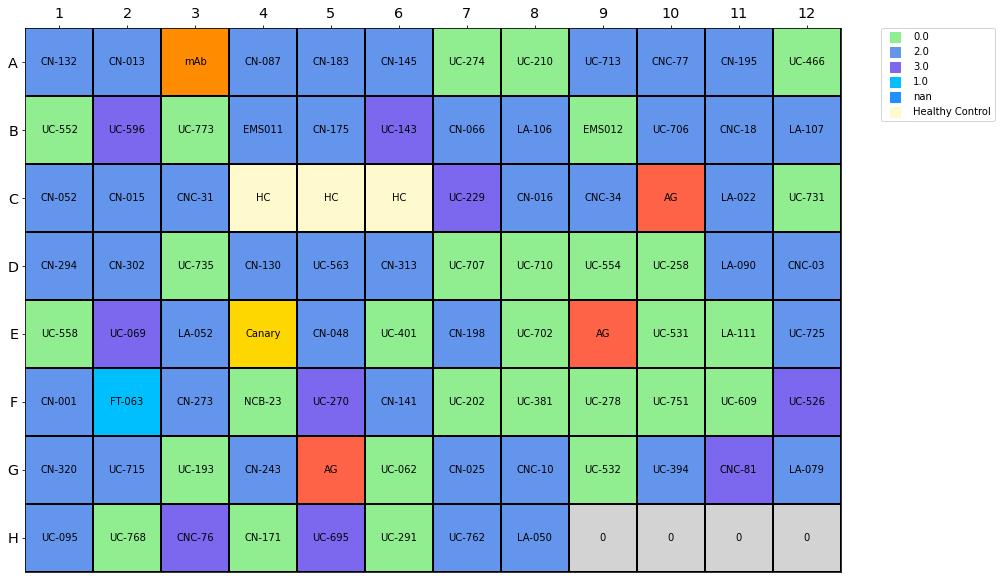

In [183]:
test2.view_plate(plates2[4], cmap_=None, view_bin=False, key=True)

# example 2: haleigh's TBI plates
I had two cohorts I wanted to evenly distributed, stored in the `TBI_cohort` category. I wanted a block of 30 healthies per plate and I wanted each sample to have one technical replicated (`duplicate_=2`)

## read in metadata and make plates

In [69]:
df3=pd.read_csv('~/phip_seq/tbi/data/metadata_10622.csv',index_col=1, header=0)
df3.head()

,sequencing_id,sample_type,PatientNum,Site,Age,Sex,RaceAmericanIndian,RaceAlaskan,RaceAmAl,RaceAsian,...,ICHponsright,ICHponsleft,ICHmedullaright,ICHmedullaleft,ICHcerebellumright,ICHcerebellumleft,MidlineShiftmm,cisternalcompressionSeverity,Fourthventricleshift,Thirdventricleobliteration
sample_id,,,,,,,,,,,,,,,,,,,,,
BR-1006-P06,TBI_BR-1006-P06_A2_08292022_S98_R1_001,TBI,BR-1006,3.0,20.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BR-1012-P06,TBI_BR-1012-P06_A4_08292022_S100_R1_001,TBI,BR-1012,3.0,60.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BR-1013-P06,TBI_BR-1013-P06_A6_08292022_S102_R1_001,TBI,BR-1013,3.0,28.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BR-1029-P09,TBI_BR-1029-P09_D8_08292022_S131_R1_001,TBI,BR-1029,3.0,53.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BR-1030-P10,TBI_BR-1030-P10_D1_08292022_S124_R1_001,TBI,BR-1030,3.0,52.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
df3=df3[df3.sample_type=='TBI']

In [73]:
df3['TBI_cohort']=['MtSinai' if x.split('-')[0] =='MS' else 'TRACK' for x in df3.index]
df3['TBI_cohort'].value_counts()

TRACK      15
MtSinai    15
Name: TBI_cohort, dtype: int64

In [77]:
df3['bin_cohort']=df3.TBI_cohort.map({'TRACK':0, 'MtSinai':1})

In [79]:
tbi=Metadata(df3, 'bin_cohort',4,1,1, block_=30, duplicate_=2)
tbi_dict=tbi.allocate_samples_to_plate()
tbi_plates=tbi.create_plates(tbi_dict)

60


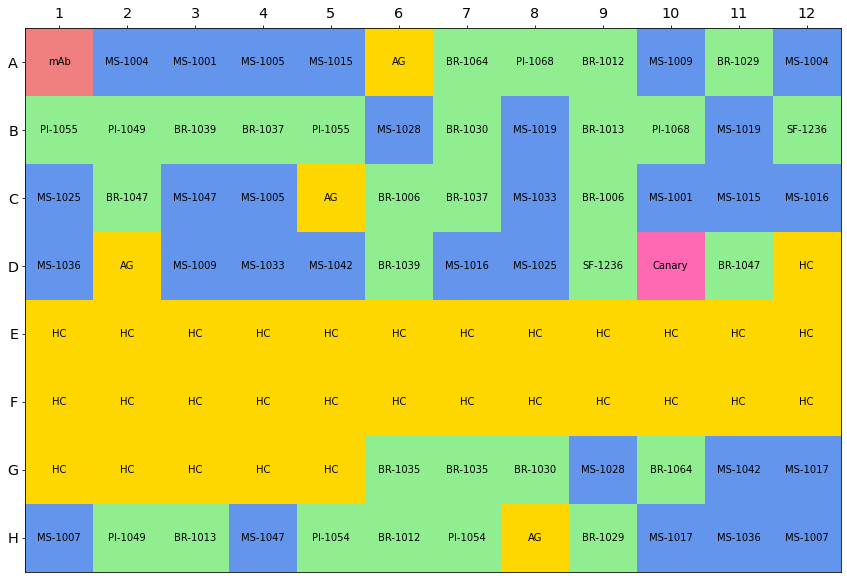

In [123]:
tbi.view_plate(tbi_plates[1], cmap_=None, view_bin=False)

## how to save plates in diff formats 

### save it as a 96 well plate format that you can open in excel 

In [124]:
X=tbi_plates[1]
df1=pd.DataFrame(data=X, columns=['1','2','3','4','5','6','7','8','9','10','11','12'], 
index=['A','B','C','D','E','F','G','H'])
df1.to_csv('../phip_seq/tbi/phip-seq_112723/plate_map.csv')


### save it as a list of locations (new_loc1=technical replicate 1, new_locs2= replicated 2) i can compare to an original platemap (original_loc)

In [125]:
locs_df=pd.DataFrame(data=None, index=df3.index, columns=['original_loc','new_loc1', 'new_loc2'])
for l in locs_df.index:
    match=[]
    for i in df1.index:
        for j in df1.columns:
            if df1.loc[i,j]==l:
                match.append(i+j)
    locs_df.loc[l,'original_loc']=df3.loc[l,'plate_loc_og']
    locs_df.loc[l,'new_loc1']=match[0]
    locs_df.loc[l,'new_loc2']=match[1]

locs_df.to_csv('../phip_seq/tbi/phip-seq_112723/plate_map_listed.csv')
